In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

import time
from google.colab import files
from tools import Kaczmarz_methods, soft_skrinkage, myphantom
from skimage.transform import radon, iradon
from scipy import sparse

In [2]:
# Fixing random state for reproducibility
np.random.seed(1234)

# Implementation of differents methods:
  - Randomized Bregman Kaczmarz method (BK)
  - Accelerated Randomized Bregman Kaczmarz method (ARBK)
  - Nesterov Randomized Bregman Kaczmarz method (NRBK)
  - Restarted Accelerated Randomized Bregman Kaczmarz method (RARBK)

# CT-Example

In [4]:
# generate the radon matrix in a quite stupid way by applying it to the standard basis…
N = 50
numAngles = 60
angles = np.linspace(0,180,numAngles,endpoint=False)

# calc one sinogram to be sure that dimensions are ok
x = np.zeros((N,N))
sinogram = radon(x, theta=angles, circle=True)

M = np.prod(sinogram.shape)
radon_matrix = np.zeros((M,N**2))

for j in range(N**2):
    x = np.zeros(N**2)
    x[j] = 1
    x = np.reshape(x,(N,N),order='F')

    # Compute the Radon transform
    sinogram = radon(x, theta=angles, circle=True)
    radon_matrix[:,j] = np.reshape(sinogram,(M),order='F')
    # order='F' is column-major reshaping
    # use this also for reshaping sinograms when visualizing!

/usr/local/lib/python3.10/dist-packages/skimage/transform/radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


(3000, 2500)


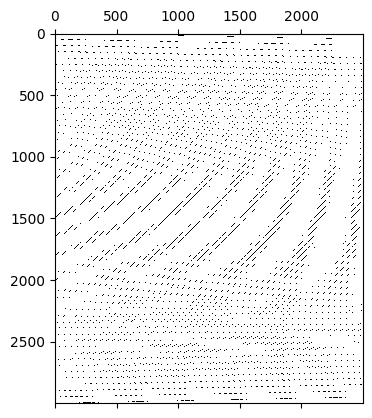

In [5]:
plt.spy(radon_matrix)
print(radon_matrix.shape)

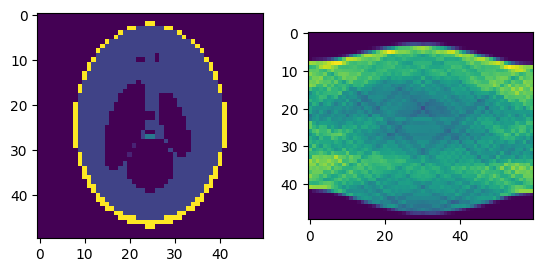

In [6]:
# generate some sparse phantom
xhat = myphantom(N)
xhat[np.abs(xhat-0.3)<0.01] = 0
b = radon_matrix@xhat


fig, (ax1,ax2) = plt.subplots(1, 2)
ax1.imshow(np.reshape(xhat,(N,N),order='F'))
ax2.imshow(np.reshape(b,(N,numAngles),order='F'))
plt.show()

In [7]:
# Set data and parameters
A = radon_matrix
m, n = A.shape

x_true = xhat.reshape(n,1)
b = b.reshape(m,1)

# 10 epochs
max_iter = 10*m

# each projection is one block:
nber_block = numAngles

# large lambda to promote sparsity
lambda_rsk = 15

# Fix the block partition
index_list = list([i for i in range(m)])
copy_index_list = index_list.copy()
Partition_lists = np.array_split(copy_index_list, nber_block)

# set tolerance and maximum number of iterations
tol = 1e-5
alpha = 1
Time_record = dict()

print(f'Shape of A {A.shape}')
print(f'Shape of the true solution {x_true.shape}')
print(f'Shape of b {b.shape}')
print(f'condition number of A {np.linalg.cond(A)}')
print(f'# nonzeros components of x^*: {n - np.sum(x_true == np.zeros((n,1)))}, percentage : {100 *(n - np.sum(x_true == np.zeros((n,1))))/n} %')

Shape of A (3000, 2500)
Shape of the true solution (2500, 1)
Shape of b (3000, 1)
condition number of A 5411.0809720662
# nonzeros components of x^*: 912, percentage : 36.48 %


In [8]:
#@title : Accelerated Randomized Bregman Kaczmarz method (ARBK)

# Run the Randomized Accelerated Bregman Kaczmarz method (ARBK)
y_start_arbk = np.zeros((m, 1))
method_arbk = 'ARBK'

Funct_values = []
Errors = []
Residuals = []
sparsity_sol = [n - np.sum(soft_skrinkage(A.T @ y_start_arbk, lambda_rsk) == np.zeros((n,1)))]

start = time.time()
y_arbk, Funct_values_arbk, Errors_arbk, Residuals_arbk, sparsity_sol_arbk  = Kaczmarz_methods(A, b, y_start_arbk, x_true, max_iter, lambda_rsk,
                                                                                              nber_block, alpha, Funct_values, Errors, Residuals,
                                                                                              sparsity_sol, tol, method_arbk, p_list=Partition_lists)

end = time.time()
Time_record[method_arbk+ f'-{nber_block}'] = end - start
print(f'The Randomized Accelerated Bregman Kaczmarz will run for a total of {max_iter} iterations in {end - start} sec. \n')
print(len(Funct_values_arbk))

Method = ARBK : number of blocks = 60, alpha = 1, lambda = 15 for 30000 iterations
The Randomized Accelerated Bregman Kaczmarz will run for a total of 30000 iterations in 136.1572048664093 sec. 

7


In [9]:
#@title : Randomized Bregman Kaczmarz method (BK)

y_start_bk = np.zeros((m, 1))
method_bk = 'BK'
funct_values = []

errors = []
residuals = []
sparsity_sol = [n - np.sum(soft_skrinkage(A.T @ y_start_bk, lambda_rsk) == np.zeros((n,1)))]

start = time.time()
y_bk, Funct_values_bk, Errors_bk, Residuals_bk, sparsity_sol_bk  = Kaczmarz_methods(A, b, y_start_bk, x_true, max_iter, lambda_rsk,
                                                                                              nber_block, alpha, funct_values, errors,
                                                                                    residuals, sparsity_sol, tol, method_bk, p_list=Partition_lists)

end = time.time()
Time_record[method_bk + f'-{nber_block}'] = end - start
print(f'The Randomized Bregman Kaczmarz will run for a total of {max_iter} iterations in {end - start} sec. \n')
print(len(Funct_values_bk))

Method = BK : number of blocks = 60, alpha = 1, lambda = 15 for 30000 iterations
The Randomized Bregman Kaczmarz will run for a total of 30000 iterations in 202.17829251289368 sec. 

10


In [18]:
#@title : Nesterov Randomized Bregman-Kaczmarz (NRBK)

y_start_nrbk = np.zeros((m, 1))
method_nrbk = 'NRBK'

Errors = []
Funct_values = []
Residuals = []
sparsity_sol = [n - np.sum(soft_skrinkage(A.T @ y_start_nrbk, lambda_rsk) == np.zeros((n,1)))]

start = time.time()
y_nrbk, Funct_values_nrbk, Errors_nrbk, Residuals_nrbk, sparsity_sol_nrbk  = Kaczmarz_methods(A, b, y_start_nrbk, x_true, max_iter, lambda_rsk,
                                                                                              nber_block, alpha, Funct_values, Errors, Residuals,
                                                                                              sparsity_sol, tol, method_nrbk, p_list=Partition_lists)

end = time.time()
Time_record[method_nrbk + f'-{nber_block}'] = end - start
print(f'The Nesterov Accelerated Coordinate Descent will run for a total of {max_iter} iterations in {end - start} sec. \n')
print(len(Funct_values_nrbk))

Method = NRBK : number of blocks = 60, alpha = 1, lambda = 15 for 30000 iterations
The Nesterov Accelerated Coordinate Descent will run for a total of 30000 iterations in 180.6247854232788 sec. 

10


In [11]:
# differents restarts

K = 165*nber_block
Restart_periods = [K for i in range(int(max_iter/(K)))]
Restart_periods.append(max_iter - sum(Restart_periods))
num_restart = len(Restart_periods)


print(f'Repeat after {Restart_periods[0]} iterations, number of restart is {num_restart}, Total number of iterations is {max_iter}')

Repeat after 9900 iterations, number of restart is 4, Total number of iterations is 30000


In [12]:
#@title :  Accelerated Randomized Bregman Kaczmarz method (ARBK) with restart

y_start_rarbk = np.zeros((m, 1))
method_arbk = 'ARBK'

Funct_values = []
Errors = []
Residuals = []
sparsity_sol = [n - np.sum(soft_skrinkage(A.T @ y_start_rarbk, lambda_rsk) == np.zeros((n,1)))]

start = time.time()
for restart in range(num_restart):
  y_rarbk, Funct_values_rarbk, Errors_rarbk, Residuals_rarbk, sparsity_sol_rarbk  = Kaczmarz_methods(A, b, y_start_rarbk, x_true, Restart_periods[restart],
                                                                                                     lambda_rsk, nber_block, alpha, Funct_values,
                                                                                                     Errors, Residuals, sparsity_sol, tol, method_arbk,
                                                                                                     p_list=Partition_lists)

  if min(Errors_rarbk[-1],Residuals_rarbk[-1]) <= tol :
    break
  x_k = soft_skrinkage(A.T @ y_rarbk, lambda_rsk)
  x_k_previous = soft_skrinkage(A.T @ y_start_rarbk, lambda_rsk)
  f_v_y = 0.5*(np.linalg.norm(x_k)**2) - b.T @ y_rarbk
  f_v_y_previous = 0.5*(np.linalg.norm(x_k_previous)**2) - b.T @ y_start_rarbk
  # condition to choose the iterate
  if f_v_y <= f_v_y_previous :
    # print('New Iterate choosen')
    y_start_rarbk = y_rarbk
  else:
    # print('Old Iterate choosen')
    y_start_rarbk = y_start_rarbk
  Funct_values, Errors, Residuals, sparsity_sol = Funct_values_rarbk, Errors_rarbk, Residuals_rarbk, sparsity_sol_rarbk

end = time.time()
Time_record['R' + method_arbk + f'-{nber_block}'] = end - start
print(f'The Randomized Accelerated Bregman Kaczmarz will run for a total of {max_iter} iterations in {end - start} sec. \n')
print(len(Funct_values_rarbk))

Method = ARBK : number of blocks = 60, alpha = 1, lambda = 15 for 9900 iterations
Method = ARBK : number of blocks = 60, alpha = 1, lambda = 15 for 9900 iterations
The Randomized Accelerated Bregman Kaczmarz will run for a total of 30000 iterations in 77.08224678039551 sec. 

6


In [13]:
Time_record

{'ARBK-60': 136.1572048664093,
 'BK-60': 202.17829251289368,
 'NRBK-60': 182.40703988075256,
 'RARBK-60': 77.08224678039551}

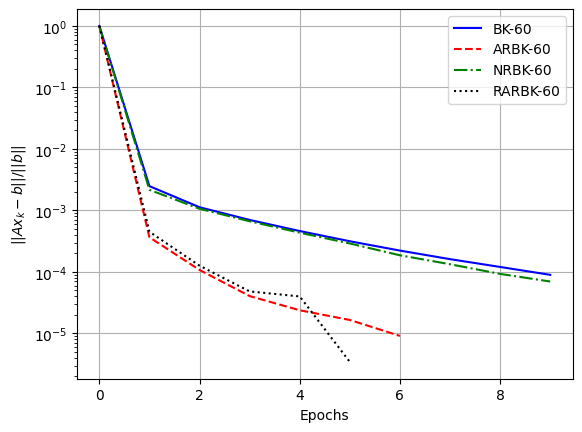

In [14]:
#@title : Residuals plots

plt.grid(True)
# plt.title('Residuals')
plt.semilogy(Residuals_bk, label= 'BK'+ f'-{nber_block}', color='blue')
plt.semilogy(Residuals_arbk, linestyle='dashed', label= 'ARBK'+ f'-{nber_block}', color='red')
plt.plot(Residuals_nrbk, linestyle='-.',label= 'NRBK'+ f'-{nber_block}', color='green')
plt.plot(Residuals_rarbk, linestyle='dotted',label= 'RARBK'+ f'-{nber_block}', color='black')
plt.xlabel("Epochs")
plt.ylabel('$||Ax_k - b||/||b||$')
plt.legend()

# name = 'residuals{}_{}.png'.format(m,n)
# plt.savefig(name, format='png', dpi=100, bbox_inches='tight')
# files.download(name)
plt.show()

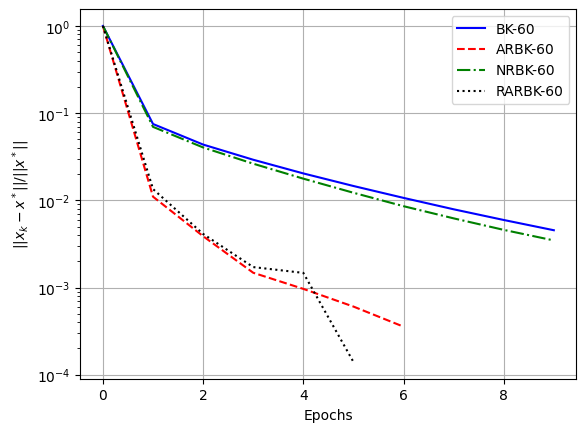

In [15]:
#@title : Errors plots

plt.grid(True)
# plt.title('Errors')
plt.semilogy(Errors_bk, label= 'BK'+ f'-{nber_block}', color='blue')
plt.semilogy(Errors_arbk, linestyle='dashed',label= 'ARBK'+ f'-{nber_block}', color='red')
plt.semilogy(Errors_nrbk, linestyle='-.',label= 'NRBK'+ f'-{nber_block}', color='green')
plt.semilogy(Errors_rarbk, linestyle='dotted',label= 'RARBK'+ f'-{nber_block}', color='black')
plt.xlabel("Epochs")
plt.ylabel('$||x_k - x^*||/||x^*||$')
plt.legend()

# name = 'errors{}_{}.png'.format(m,n)
# plt.savefig(name, format='png', dpi=100, bbox_inches='tight')
# files.download(name)
plt.show()

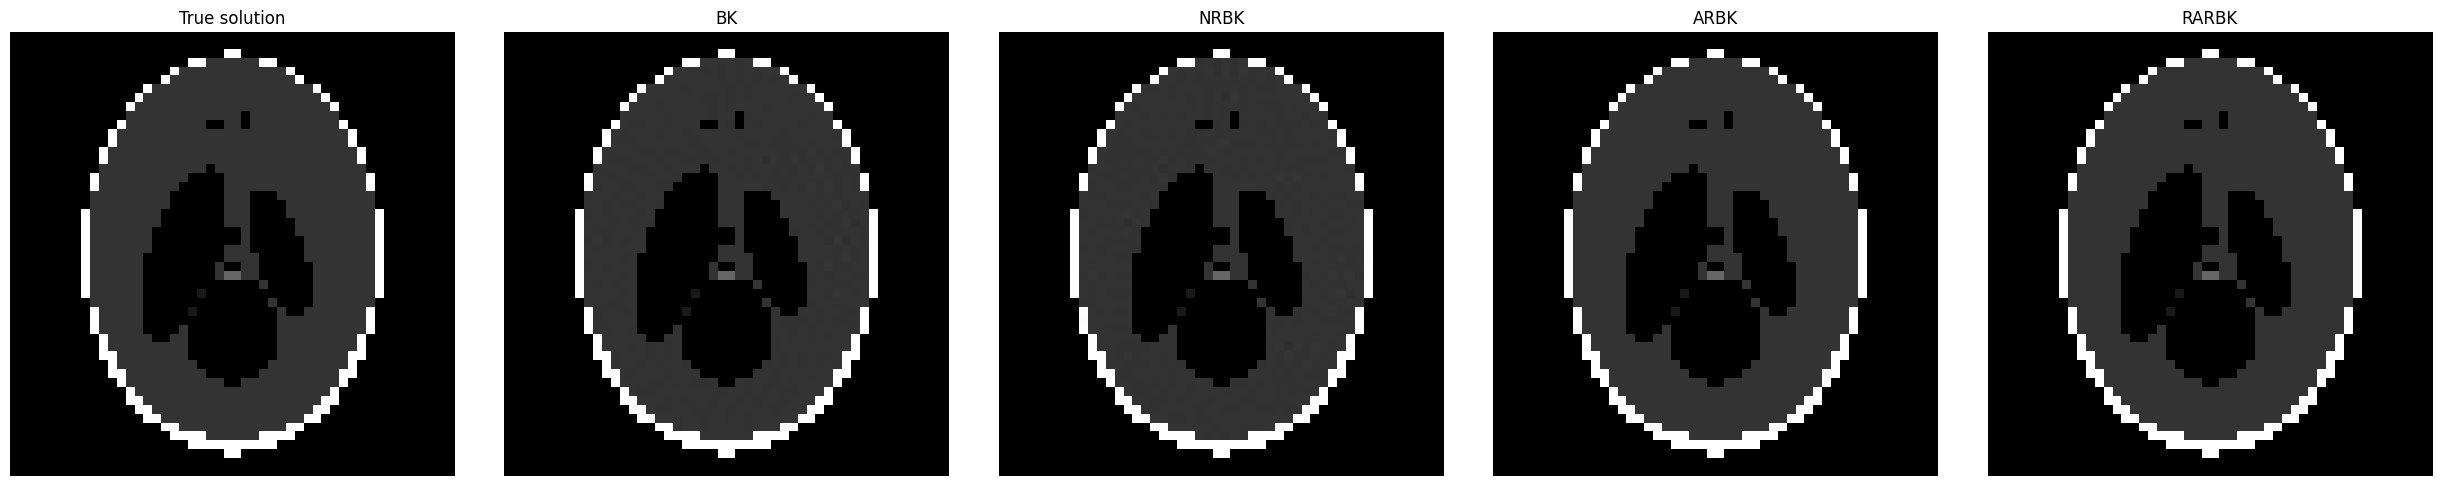

In [19]:
#@title : plot reconstructions

x_bk = soft_skrinkage(A.T @ y_bk, lambda_rsk)
x_nrbk = soft_skrinkage(A.T @ y_nrbk, lambda_rsk)
x_arbk = soft_skrinkage(A.T @ y_arbk, lambda_rsk)
x_rarbk = soft_skrinkage(A.T @ y_rarbk, lambda_rsk)

Images = [x_true, x_bk, x_nrbk, x_arbk, x_rarbk]
New = int(np.sqrt(A.shape[0]))
Titles = ['True solution', 'BK', 'NRBK', 'ARBK', 'RARBK']
fig, axes = plt.subplots(1, len(Images), figsize = (5*len(Images), 1*len(Images)))

for (ax,i) in zip(axes.flat, range(len(Images))):
    ax.set_title(f'{Titles[i]}')
    ax.imshow(Images[i].reshape(N,N,order='F'), cmap='gray')
    ax.axis('off')
fig.tight_layout(pad = 2)

# name = 'ct_reconstruction{}_{}.png'.format(m,n)
# plt.savefig(name, format='png', dpi=100, bbox_inches='tight')
# files.download(name)

plt.show()